<a href="https://colab.research.google.com/github/Ashishxyz/Transfer-Learning-For-Leaf-Disease-Prediction/blob/main/Tomato_Leaf_Disease_Classification_Using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Importing the Tomato Disease Dataset from Kaggle**

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d kaustubhb999/tomatoleaf

Dataset URL: https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf
License(s): CC0-1.0
tomatoleaf.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/tomatoleaf.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

#**Importing Libraries**

In [4]:
# Importing necessary libraries for data manipulation and numerical operations
import numpy as np
import pandas as pd

# Importing essential libraries for building and training neural networks
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Importing utilities for data preprocessing and augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Importing callback function for early stopping during training
from keras.callbacks import EarlyStopping as ES

# Utility for clearing the output in IPython environment
from IPython.display import clear_output as cls

# Libraries for visualization
import matplotlib.pyplot as plt
import plotly.express as px

# Operating system interface
import os

In [5]:
# Number of samples to process in one iteration during training
batchSize = 32

# Shape of the input images (height, width)
imageShape = (224, 224)

# Number of epochs for training the model
epochs = 10

# Number of color channels in the images (3 for RGB)
channels = 3

In [6]:
train_dir = "/content/tomato/train"
val_dir = "/content/tomato/val"

#**ETA**

In [7]:
class_names = sorted(os.listdir(train_dir))
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [8]:
class_dis = [len(os.listdir(os.path.join(train_dir, name))) for name in class_names]
class_dis

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]

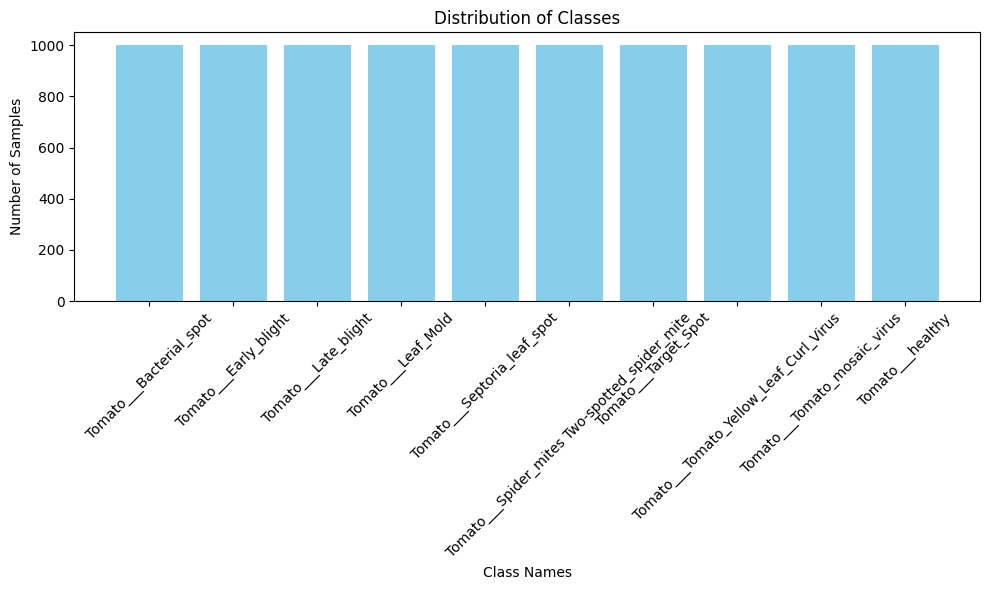

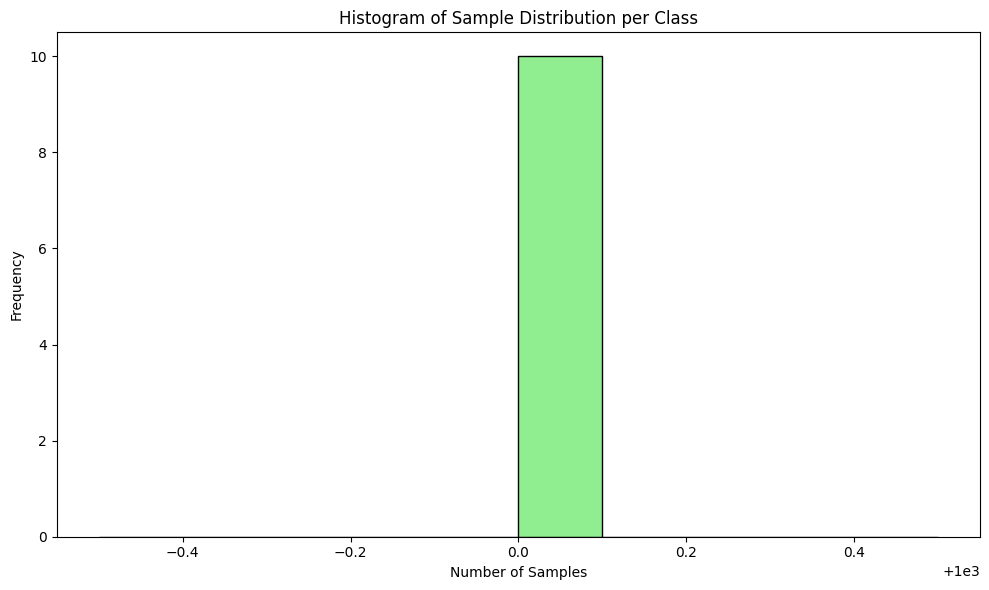

In [9]:
# Import necessary libraries for visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Create a pie chart to visualize the distribution of classes using Plotly
fig = px.pie(names=class_names, values=class_dis, hole=0.3)

# Update layout for the pie chart to center the title
fig.update_layout({
    "title": {
        "text": "Distribution of Classes",
        "x": 0.50
    }
})

# Display the pie chart
fig.show()

# Create a bar chart to visualize the distribution of classes using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_dis, color='skyblue')
plt.xlabel('Class Names')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a histogram to visualize the distribution of sample counts across classes
plt.figure(figsize=(10, 6))
plt.hist(class_dis, bins=len(class_names), color='lightgreen', edgecolor='black')
plt.xlabel('Number of Samples')
plt.ylabel('Frequency')
plt.title('Histogram of Sample Distribution per Class')
plt.tight_layout()
plt.show()

#**Data Transformation**

In [10]:
# Importing the ImageDataGenerator from Keras for data augmentation and preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Creating an ImageDataGenerator object for the training set with rescaling and validation split
train_gen = ImageDataGenerator(
    rescale=1./255.,  # Rescale pixel values from range [0, 255] to [0, 1]
    validation_split=0.2  # Reserve 20% of the training data for validation
)

# Creating an ImageDataGenerator object for the validation set with only rescaling
val_gen = ImageDataGenerator(
    rescale=1./255.  # Rescale pixel values from range [0, 255] to [0, 1]
)

In [11]:
# Create a training data generator using the flow_from_directory method
train_ds = train_gen.flow_from_directory(
    train_dir,  # Directory where the training images are stored
    target_size=imageShape,  # Resize images to the specified target size (height, width)
    batch_size=batchSize,  # Number of images to be yielded from the generator per batch
    subset='training',  # Specify that this generator is for the training subset
    class_mode='categorical'  # Specify that the labels are categorical (one-hot encoded)
)

# Create a validation data generator using the flow_from_directory method
val_ds = train_gen.flow_from_directory(
    train_dir,  # Directory where the training images are stored
    target_size=imageShape,  # Resize images to the specified target size (height, width)
    batch_size=batchSize,  # Number of images to be yielded from the generator per batch
    subset='validation',  # Specify that this generator is for the validation subset
    class_mode='categorical'  # Specify that the labels are categorical (one-hot encoded)
)

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [12]:
# Create a test data generator using the flow_from_directory method
test_ds = val_gen.flow_from_directory(
    val_dir,            # Directory where the validation images are stored
    target_size=imageShape,    # Resize images to the specified target size (height, width)
    batch_size=batchSize,      # Number of images to be yielded from the generator per batch
    class_mode='categorical'   # Specify that the labels are categorical (one-hot encoded)
)

Found 1000 images belonging to 10 classes.


In [13]:
# Define a function to plot images with their corresponding labels
def plot_images(data, class_names):

    # Set the number of rows and columns for the subplot grid
    r, c = 3, 4
    imgLen = r*c

    # Create a figure with a specified size
    plt.figure(figsize=(20, 15))

    # Initialize a counter variable
    i = 1

    # Iterate over the data generator
    for images, labels in iter(data):

        # Randomly select an index within the batch
        id = np.random.randint(len(images))

        # Extract the image and label at the selected index
        img = tf.expand_dims(images[id], axis=0)  # Expand dimensions to add batch size dimension
        lab = class_names[np.argmax(labels[id])]  # Get the label corresponding to the one-hot encoded vector

        # Create a subplot within the grid and plot the image
        plt.subplot(r, c, i)
        plt.imshow(img[0])
        plt.title(lab)
        plt.axis('off')

        # Clear the current output
        cls()

        # Increment the counter
        i += 1

        # Break the loop if the desired number of images has been plotted
        if i > imgLen:
            break

    # Display the plot
    plt.show()

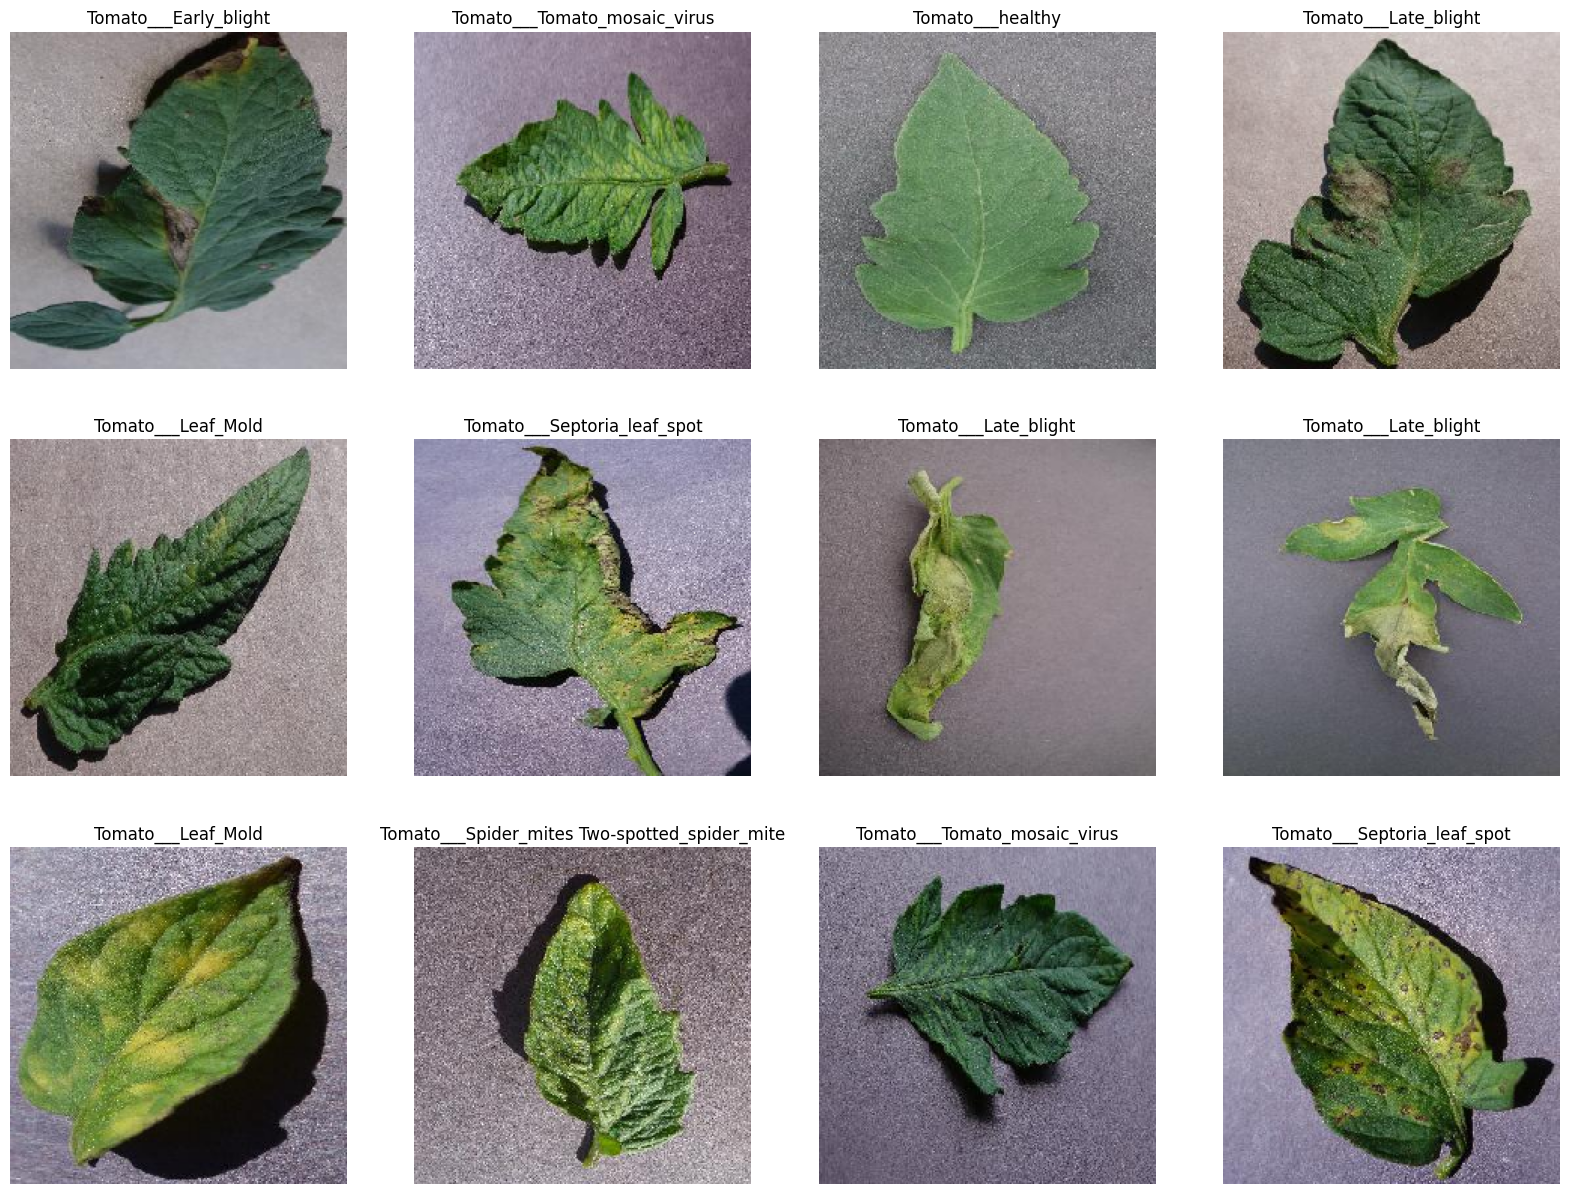

In [14]:
plot_images(train_ds, class_names)

#**Model (Transfer Learning)**

In [15]:
# Define a function to create a model architecture
def get_model():

    # Load the pre-trained InceptionV3 model without the top layer
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Get the output tensor of the base model
    base_model_output = base_model.output

    # Add custom layers on top of the base model
    x = Flatten()(base_model_output)  # Flatten the output tensor
    x = Dense(512, activation='relu')(x)  # Add a fully connected layer with 512 units and ReLU activation
    x = Dense(len(class_names), activation='softmax')(x)  # Add a softmax layer for classification

    # Create a new model with the specified input and output tensors
    model = Model(inputs=base_model.input, outputs=x)

    return model

In [16]:
# Create the model using the get_model function
model = get_model()

# Compile the model with specified loss function, optimizer, and evaluation metrics
model.compile(
    loss="categorical_crossentropy",  # Categorical cross-entropy loss for multi-class classification
    optimizer="sgd",  # Stochastic Gradient Descent optimizer
    metrics=["accuracy"]  # Accuracy metric to monitor during training
)

# Print the summary of the model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

#**Training**

In [17]:
# Train the model using the fit method
history = model.fit(
    train_ds,  # Training dataset generator
    validation_data=val_ds,  # Validation dataset generator
    epochs=10,  # Number of epochs (iterations over the entire dataset)
    steps_per_epoch=len(train_ds),  # Number of steps (batches) per epoch
    validation_steps=len(val_ds),  # Number of steps (batches) to validate at the end of each epoch
    callbacks=[ES(monitor="val_loss", patience=5)]  # Early stopping callback to prevent overfitting
)

Epoch 1/10
250/250 [==============================] - 37s 108ms/step - loss: 1.7312 - accuracy: 0.5278 - val_loss: 0.7474 - val_accuracy: 0.7545
Epoch 2/10
250/250 [==============================] - 23s 93ms/step - loss: 0.6947 - accuracy: 0.7599 - val_loss: 0.6893 - val_accuracy: 0.7715
Epoch 3/10
250/250 [==============================] - 25s 99ms/step - loss: 0.4782 - accuracy: 0.8320 - val_loss: 0.7459 - val_accuracy: 0.7585
Epoch 4/10
250/250 [==============================] - 23s 93ms/step - loss: 0.3390 - accuracy: 0.8854 - val_loss: 0.5265 - val_accuracy: 0.8120
Epoch 5/10
250/250 [==============================] - 24s 95ms/step - loss: 0.2485 - accuracy: 0.9179 - val_loss: 0.4338 - val_accuracy: 0.8590
Epoch 6/10
250/250 [==============================] - 24s 96ms/step - loss: 0.1614 - accuracy: 0.9488 - val_loss: 0.4920 - val_accuracy: 0.8450
Epoch 7/10
250/250 [==============================] - 24s 94ms/step - loss: 0.1062 - accuracy: 0.9706 - val_loss: 0.4146 - val_accuracy

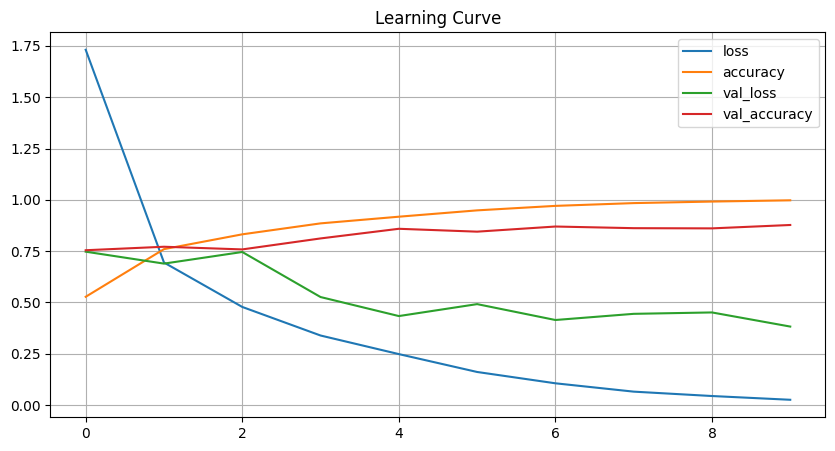

In [18]:
# Create a DataFrame from the history object returned by model.fit()
learning_curve = pd.DataFrame(history.history)

# Plot the learning curve using Matplotlib
learning_curve.plot(figsize=(10, 5))  # Plotting the learning curve with a specified figure size
plt.title("Learning Curve")  # Adding a title to the plot
plt.grid()  # Adding grid lines to the plot

#**Prediction**

In [19]:
# Define a function to predict images and display them along with their actual and predicted labels
def predictImages(data, class_names, model):

    # Set the number of rows and columns for the subplot grid
    r, c = 3, 4
    imgLen = r*c

    # Create a figure with a specified size
    plt.figure(figsize=(20, 15))

    # Initialize a counter variable
    i = 1

    # Iterate over the data generator
    for images, labels in iter(data):

        # Randomly select an index within the batch
        id = np.random.randint(len(images))

        # Expand dimensions to add batch size dimension
        img = tf.expand_dims(images[id], axis=0)

        # Create a subplot within the grid and plot the image
        plt.subplot(r, c, i)
        plt.imshow(img[0])

        # Predict the label of the image using the model
        predicted = model.predict(img)
        predicted = class_names[np.argmax(predicted)]

        # Get the actual label of the image
        actual = class_names[np.argmax(labels[id])]

        # Add title to the subplot with actual and predicted labels
        plt.title(f"Actual: {actual}\nPredicted: {predicted}")
        plt.axis('off')

        # Clear the current output
        cls()

        # Increment the counter
        i+=1

        # Break the loop if the desired number of images have been plotted
        if i > imgLen:
            break

    # Display the plot
    plt.show()

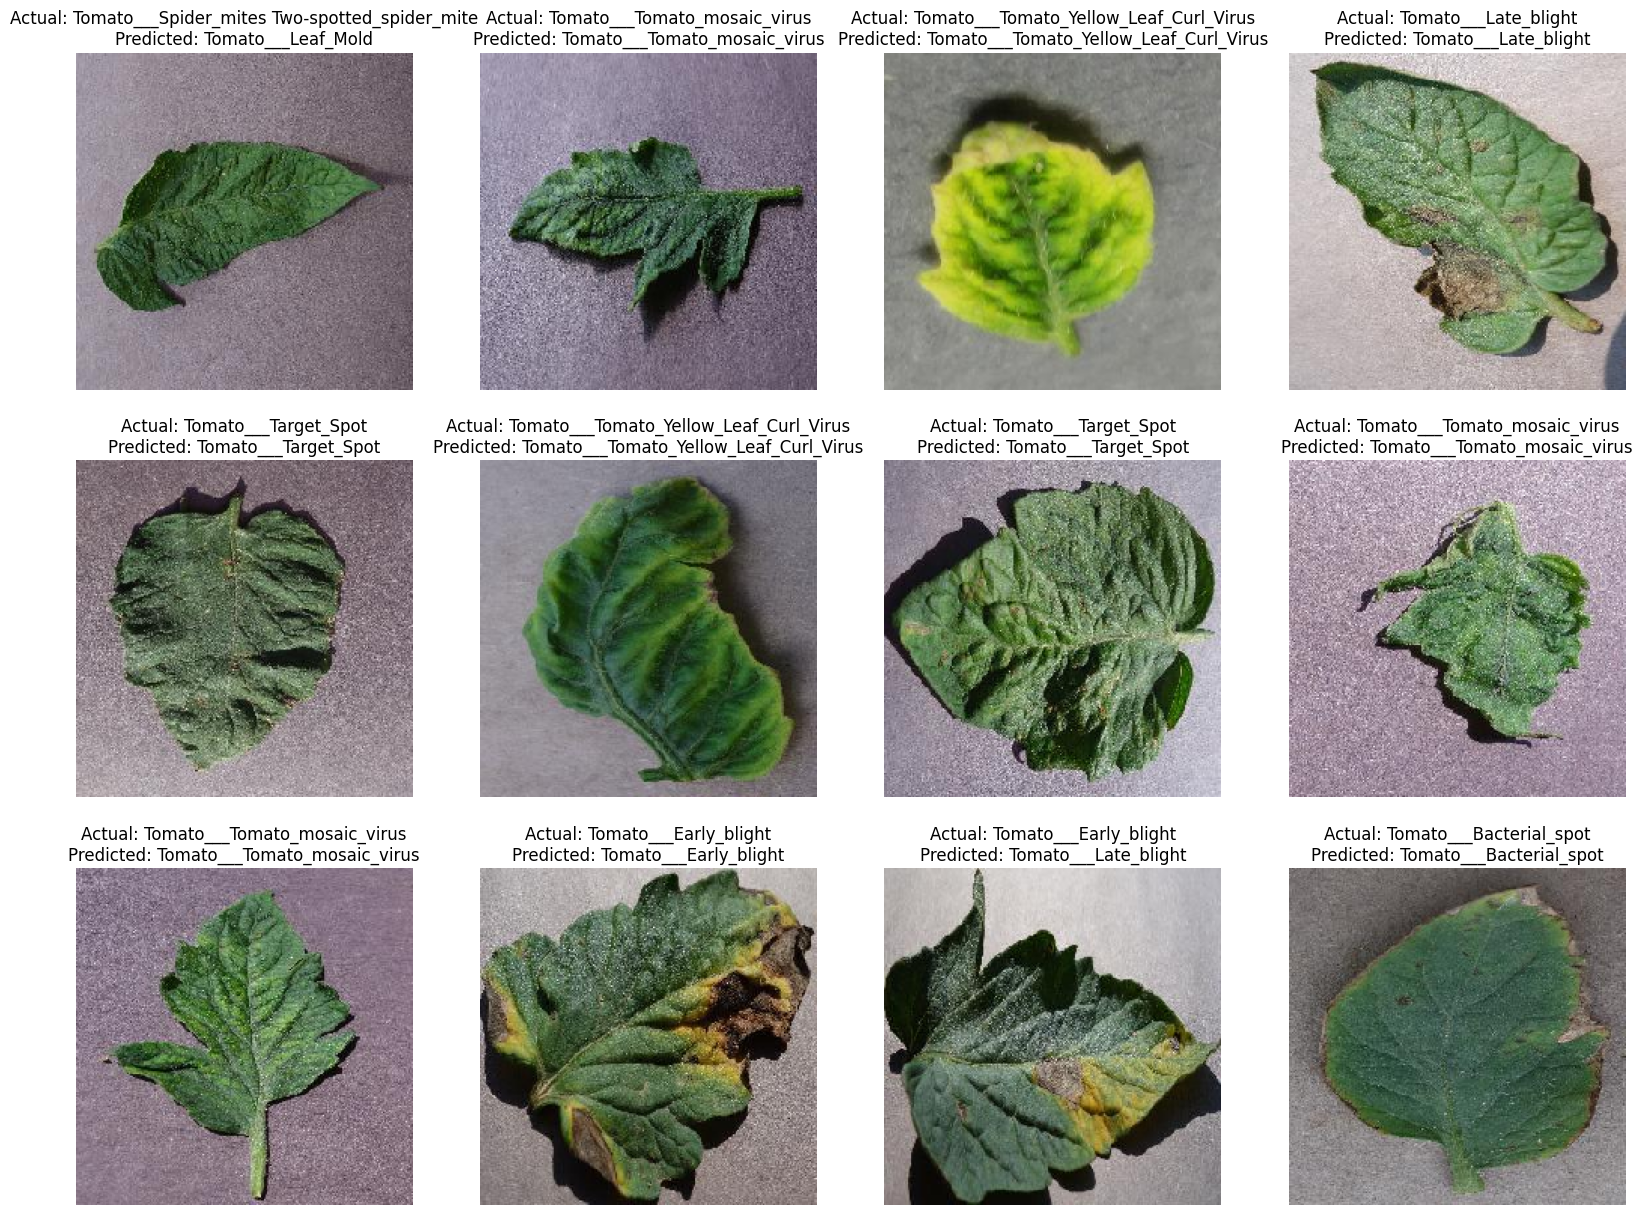

In [20]:
predictImages(test_ds, class_names, model)